In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import arch
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
#pd.set_option('display.max_colwidth', -1)  # or 199
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from scipy.optimize import minimize
import scipy.stats as ss
from sklearn.metrics import mean_absolute_error, r2_score

plt.style.use('seaborn-bright')

i = 23

# Preprocessing

Загружаем данные

In [2]:
factors = pd.read_csv('data/Factors.csv')

if 'Unnamed: 0' in factors.columns:
    factors = factors.drop('Unnamed: 0', axis=1)
factors = factors.rename(columns={'datadate': 'date'})
factors['date'] = pd.to_datetime(factors['date'])

sp500_raw = pd.read_csv('data/SP500 Prices.csv')
if 'Unnamed: 0' in sp500_raw.columns:
    sp500_raw = sp500_raw.drop('Unnamed: 0', axis=1)
sp500_raw = sp500_raw.rename(columns={'datadate': 'date'})
sp500_raw['date'] = pd.to_datetime(sp500_raw['date'])

In [3]:
factors.sample(2)

,gvkey,date,sector,mkval,dividendyield,earningsyield,roe,roa,momentum,tradingvolumeusd1m,beta5yr,debttoequity,salesgrowth5yr,earningschange5yrtosales
130629,63892,2014-04-30,Energy,33677.74756,1.324335,6.729126,9.988104,6.389515,21.041273,6731.596940,1.492950,15.605587,37.991144,1.235738
62126,9217,2006-07-31,Materials,10185.55588,2.862099,6.721011,16.825165,7.032205,11.635610,1198.229884,1.138049,53.694221,32.472446,8.853843


In [4]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185230 entries, 0 to 185229
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   gvkey                     185230 non-null  int64         
 1   date                      185230 non-null  datetime64[ns]
 2   sector                    185225 non-null  object        
 3   mkval                     185059 non-null  float64       
 4   dividendyield             185072 non-null  float64       
 5   earningsyield             184658 non-null  float64       
 6   roe                       178148 non-null  float64       
 7   roa                       184817 non-null  float64       
 8   momentum                  183035 non-null  float64       
 9   tradingvolumeusd1m        184766 non-null  float64       
 10  beta5yr                   184378 non-null  float64       
 11  debttoequity              177493 non-null  float64       
 12  sa

# Return calculation

Для начала, объединим котировки за 2000-2020 года в одну таблицу

In [5]:
prices_df = pd.DataFrame()
prices_df_list = []
for s in tqdm(range(2000, 2021, 1)):
    file_name = 'data/Prices (' + str(s) + ').csv' # make filename according to the year
    df_tmp = pd.read_csv(file_name).drop('Unnamed: 0', axis=1).rename(columns={'datadate': 'date'}) # import data from file
    df_tmp = df_tmp.drop_duplicates()
    
    df_tmp['date'] = pd.to_datetime(df_tmp['date']) # change column type to 'datetime'
    
    df_tmp['iid'] = df_tmp['iid'].replace([90, 19, 91], [6, 7, 8])
    
    df_tmp['gvkey+iid'] = df_tmp['gvkey'].astype('str') + df_tmp['iid'].astype('str') # join gvkey and iid
    df_tmp['gvkey+iid'] = df_tmp['gvkey+iid'].astype('int')
    #df_tmp = df_tmp.drop('iid', axis=1)
    prices_df_list.append(df_tmp)

prices_df = pd.concat(prices_df_list, axis=0)

100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


In [6]:
prices_df.sample(5)

,gvkey,iid,date,prccddiv,gvkey+iid
259443,113419,1,2003-07-26,16.700000,1134191
120792,24216,1,2017-01-28,13.463378,242161
175531,61739,1,2019-10-25,92.668179,617391
83213,9904,1,2017-06-09,8.795803,99041
298592,155394,2,2004-10-02,2.368750,1553942


Создадим сводную таблицу на основе *prices_df*, где в качестве столбцов будут идентификаторы акций, а в качестве индекса - последние даты каждого месяца 2000-2020гг. Данное преобразование необходимо для корректного расчета доходностей и стандартных отклонений (чтобы акции не смешивались между собой)

In [7]:
risk_free = pd.read_csv('data/Risk-free.csv')\
              .rename(columns={'DATE': 'date', 
                               'IRLTLT01USM156N': 'risk-free'})

risk_free['date'] = pd.to_datetime(risk_free['date'])

risk_free = risk_free.set_index('date').resample('M')\
                     .apply(lambda x: x / (100 * 12)).shift(1).fillna(0)

risk_free = risk_free.loc[:pd.to_datetime('2020-12-31')]
risk_free.describe().T

,count,mean,std,min,25%,50%,75%,max
risk-free,252.0,0.002756,0.00111,0.0,0.00186,0.002654,0.003592,0.00555


In [8]:
pivot_prices = pd.pivot_table(prices_df, columns=['gvkey+iid'], index=['date'], values=['prccddiv']) # pivot

returns_df = pivot_prices.pct_change(axis='index').apply(lambda x: x+1)\
                    .resample('M').prod().apply(lambda x: x-1) # calculate monthly return
returns_df = returns_df.replace(0, np.nan)

for col in returns_df.columns:
    returns_df[col] = returns_df[col] - risk_free['risk-free']

std_df = pivot_prices.pct_change(axis='index')\
                   .resample('M').std().apply(lambda x: x*np.sqrt(252/12)) # calculate monthly std
std_df = std_df.replace(0, np.nan)


Для упрощения вычислений в дальнейшем создадим лагированные доходности и стандартные отклонения (лаг -1)

In [9]:
std_df_shifted = std_df.shift(1)  # make shifted returns and std's
returns_df_shifted = returns_df.shift(1)

In [10]:
returns_df_shifted.head(5)

prccddiv                                                  \
gvkey+iid    10131     10451   10454     10751     10781     11611     
date                                                                   
2000-01-31       NaN       NaN     NaN       NaN       NaN       NaN   
2000-02-29 -0.091301 -0.196828     NaN  0.022036 -0.098795  0.244060   
2000-03-31  0.355587 -0.022972     NaN -0.110813  0.007886  0.081256   
2000-04-30  0.195124  0.287838     NaN  0.014929  0.060855  0.453033   
2000-05-31  0.122394  0.063411     NaN  0.251682  0.092384  0.528190   

                                                                        \
gvkey+iid    11641     11771     12091     12301     12391     12401     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29 -0.134276 -0.042459 -0.117318 -0.092527 -0.048426 -0.049085   
2000-03-31 -0.034121 -0.233250 -0.136352 -0.174177 -0.132623 -0.202271   
2000-04-30  0.009973  0.344111  0.105850  0.129001  0.108602  0.254771   
2000-05-31 -0.002458  0.041355  0.087091 -0.048876 -0.013091  0.057354   

                                                                        \
gvkey+iid    12431     12461     12791     13001     13181     13271     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29 -0.054381  0.183486  0.018561 -0.167931 -0.192744  0.461287   
2000-03-31 -0.158663 -0.132372 -0.057942  0.001243 -0.131747  0.728032   
2000-04-30  0.026764 -0.121505  0.078305  0.089372  0.085084 -0.351107   
2000-05-31 -0.043749 -0.055722  0.091849  0.057654  0.048143  0.089520   

                                                                        \
gvkey+iid    13561     13591     13801     14081     14401     14471     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29 -0.160392  0.030686 -0.062775 -0.122873  0.042802 -0.007508   
2000-03-31 -0.019295  0.022471 -0.054904 -0.244784 -0.150876 -0.191058   
2000-04-30  0.020114  0.018417  0.276055  0.137424  0.054567  0.104487   
2000-05-31 -0.081729  0.167828 -0.020691 -0.005217  0.223295  0.000245   

                                                                        \
gvkey+iid    14491     14651     14681     14781     14871     15672     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29 -0.079470 -0.190280 -0.063492  0.199045 -0.034682 -0.182561   
2000-03-31 -0.162207 -0.149761 -0.217345 -0.076881 -0.158245 -0.075550   
2000-04-30  0.240721  0.070016  0.052538  0.230199  0.233420  0.055499   
2000-05-31  0.066114 -0.007444 -0.012066  0.041295 -0.003504  0.102891   

                                                                        \
gvkey+iid    15811     15981     16021     16191     16321     16511     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29  0.038130  0.154098  0.060354 -0.097087  0.005376  0.214521   
2000-03-31 -0.069531 -0.235664  0.065108 -0.184761  0.676268  0.070537   
2000-04-30  0.139238  0.135327 -0.105342  0.054291  0.018414 -0.081191   
2000-05-31 -0.177248  0.062965 -0.092793 -0.030321 -0.051024  0.281669   

                                                                        \
gvkey+iid    16611     16631     16781     16901     17041     17221     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29 -0.042424 -0.047619 -0.011844  0.009119  0.083374 -0.030928   
2000-03-31  0.205420 -0.053168 -0.005550  0.099269  0.327328 -0.145523   
2000-04-30  0.076448 -0.03

In [11]:
returns_df_shifted.columns[50:70]

MultiIndex([('prccddiv', 19201),
            ('prccddiv', 19761),
            ('prccddiv', 19881),
            ('prccddiv', 19951),
            ('prccddiv', 19981),
            ('prccddiv', 20191),
            ('prccddiv', 20441),
            ('prccddiv', 20551),
            ('prccddiv', 20851),
            ('prccddiv', 20861),
            ('prccddiv', 21111),
            ('prccddiv', 21361),
            ('prccddiv', 21461),
            ('prccddiv', 21541),
            ('prccddiv', 21762),
            ('prccddiv', 21841),
            ('prccddiv', 21891),
            ('prccddiv', 22201),
            ('prccddiv', 22261),
            ('prccddiv', 22301)],
           names=[None, 'gvkey+iid'])

/Users/vladislav/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/vladislav/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


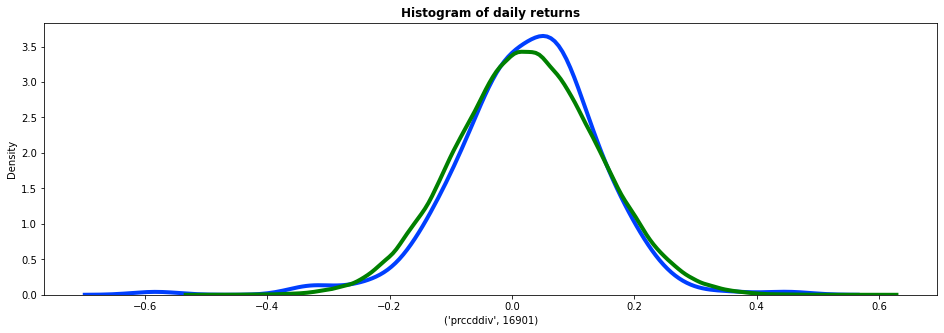

In [12]:
fig = plt.figure(figsize=(16, 5))

number = 16901

sns.distplot(returns_df_shifted[('prccddiv',   number)], hist=False, kde=True, 
             bins=50,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(np.random.normal(loc=returns_df_shifted[('prccddiv',   number)].mean(), 
                 scale=returns_df_shifted[('prccddiv',   number)].std(), 
                 size=len(returns_df_shifted[('prccddiv',   number)])+250000), hist=False, color = 'green', kde=True, 
             bins=50,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

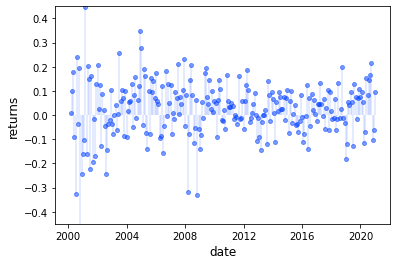

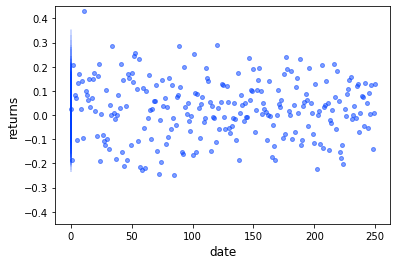

In [13]:
fig, ax = plt.subplots()

ax.plot(returns_df_shifted[('prccddiv',   number)], linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(returns_df_shifted[('prccddiv',   number)].index, 0, returns_df_shifted[('prccddiv',   number)].values, lw=0.2)


ax.set_ylim(-0.45, 0.45)
ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()



fig, ax = plt.subplots()

ax.plot(np.random.normal(loc=returns_df_shifted[('prccddiv',   number)].mean(), 
                 scale=returns_df_shifted[('prccddiv',   number)].std(), 
                 size=np.sum(~returns_df_shifted[('prccddiv',   number)].isna())), linestyle='', 
                 marker='o', alpha=0.5, ms=4)
ax.vlines(pd.Series(np.random.normal(loc=returns_df_shifted[('prccddiv',   number)].mean(), 
                 scale=returns_df_shifted[('prccddiv',   number)].std(), 
                 size=np.sum(~returns_df_shifted[('prccddiv',   number)].isna()))), 
          0, pd.Series(np.random.normal(loc=returns_df_shifted[('prccddiv',   number)].mean(), 
                 scale=returns_df_shifted[('prccddiv',   number)].std(), 
                 size=np.sum(~returns_df_shifted[('prccddiv',   number)].isna()))), lw=0.2)


ax.set_ylim(-0.45, 0.45)
ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

In [14]:
def check_heavy_tails(returns, alpha=.05, log_returns=True):
    
    if log_returns:
        returns = pd.Series(returns).apply(lambda x: np.log(1+x))
        
    qq_test = returns.quantile(alpha)
    prob_th = st.norm.cdf(qq_test, loc=returns.mean(), scale=returns.std())
    
    return prob_th

In [15]:
check_heavy_tails(returns_df_shifted[('prccddiv', number)], alpha=.05)

0.07290814977310273

In [16]:
returns_df_shifted[('prccddiv', number)]

date
2000-01-31         NaN
2000-02-29    0.009119
2000-03-31    0.099269
2000-04-30    0.179409
2000-05-31   -0.091733
2000-06-30   -0.327914
2000-07-31    0.241657
2000-08-31   -0.034916
2000-09-30    0.194220
2000-10-31   -0.582294
2000-11-30   -0.245125
2000-12-31   -0.161333
2001-01-31   -0.103252
2001-02-28    0.449415
2001-03-31   -0.160369
2001-04-30    0.205065
2001-05-31    0.150886
2001-06-30   -0.221623
2001-07-31    0.160922
2001-08-31   -0.196228
2001-09-30   -0.017139
2001-10-31   -0.168023
2001-11-30    0.128231
2001-12-31    0.209176
2002-01-31    0.024294
2002-02-28    0.124525
2002-03-31   -0.126368
2002-04-30    0.086692
2002-05-31    0.020949
2002-06-30   -0.044309
2002-07-31   -0.243785
2002-08-31   -0.142935
2002-09-30   -0.037296
2002-10-31   -0.020499
2002-11-30    0.105051
2002-12-31   -0.038753
2003-01-31   -0.078859
2003-02-28   -0.001265
2003-03-31    0.041890
2003-04-30   -0.061211
2003-05-31    0.002483
2003-06-30    0.259007
2003-07-31    0.058863
2003-0

In [17]:
returns_df_shifted.head(2)

prccddiv                                                           \
gvkey+iid    10131     10451   10454     10751     10781    11611     11641     
date                                                                            
2000-01-31       NaN       NaN     NaN       NaN       NaN      NaN       NaN   
2000-02-29 -0.091301 -0.196828     NaN  0.022036 -0.098795  0.24406 -0.134276   

                                                                        \
gvkey+iid    11771     12091     12301     12391     12401     12431     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29 -0.042459 -0.117318 -0.092527 -0.048426 -0.049085 -0.054381   

                                                                        \
gvkey+iid    12461     12791     13001     13181     13271     13561     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29  0.183486  0.018561 -0.167931 -0.192744  0.461287 -0.160392   

                                                                       \
gvkey+iid    13591     13801     14081     14401     14471    14491     
date                                                                    
2000-01-31       NaN       NaN       NaN       NaN       NaN      NaN   
2000-02-29  0.030686 -0.062775 -0.122873  0.042802 -0.007508 -0.07947   

                                                                      \
gvkey+iid   14651     14681     14781     14871     15672    15811     
date                                                                   
2000-01-31      NaN       NaN       NaN       NaN       NaN      NaN   
2000-02-29 -0.19028 -0.063492  0.199045 -0.034682 -0.182561  0.03813   

                                                                        \
gvkey+iid    15981     16021     16191     16321     16511     16611     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29  0.154098  0.060354 -0.097087  0.005376  0.214521 -0.042424   

                                                                        \
gvkey+iid    16631     16781     16901     17041     17221     17621     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29 -0.047619 -0.011844  0.009119  0.083374 -0.030928 -0.314607   

                                                                       \
gvkey+iid    17941     18311     18371     18481     18781    18911     
date                                                                    
2000-01-31       NaN       NaN       NaN       NaN       NaN      NaN   
2000-02-29 -0.011385 -0.268641  0.011029 -0.109827 -0.092685 -0.11949   

                                                                       \
gvkey+iid    19131     19201     19761    19881     19951     19981     
date                                                                    
2000-01-31       NaN       NaN       NaN      NaN       NaN       NaN   
2000-02-29 -0.070326 -0.035985  0.172107 -0.07619  0.038793 -0.068359   

                                                                        \
gvkey+iid    20191     20441     20551     20851     20861     21111     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29  0.020002 -0.152142 -0.074205 -0.094064  0.016915 -0.027842   

                                                                        \
gvkey+iid    21361     21461     21541     21762     21841     21891     
date                                                                     
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN

In [18]:
def filter_stocks(df, stock):
    
    if type(stock)==tuple: 
        returns = df[stock]
    elif type(stock)==int:
        returns = df[tuple('prccddiv', stock)]
    else: 
        return 0
    
    # filter out stocks without full 20 years +-5% history of returns
    if (returns.isna().sum()/252) <= .05 and returns.tail(10).isna().sum() == 0:
        return 1
    else:
        return 0

In [19]:
res = 0

for stock in returns_df_shifted.columns:
    res += filter_stocks(returns_df_shifted, stock)

print(len(returns_df_shifted.columns))
print(res)

1023
484


Теперь вернем сводные таблицы обратно к melted формату

In [20]:
returns_df_melted = pd.melt(returns_df, ignore_index=False)
returns_df_melted.columns = ['prccddiv', 'gvkey+iid', 'return'] 
returns_df_melted['gvkey'] = returns_df_melted['gvkey+iid'].astype('str').apply(lambda x: x[:-1]).astype('int')
returns_df_melted = returns_df_melted.drop('prccddiv', axis=1)

std_df_melted = pd.melt(std_df, ignore_index=False)
std_df_melted.columns = ['prccddiv', 'gvkey+iid', 'std'] 
std_df_melted = std_df_melted.drop(['prccddiv', 'gvkey+iid'], axis=1)

returns_df_shifted_melted = pd.melt(returns_df_shifted, ignore_index=False)
returns_df_shifted_melted.columns = ['prccddiv', 'gvkey+iid', 'return(+1)'] 
returns_df_shifted_melted = returns_df_shifted_melted.drop(['prccddiv', 'gvkey+iid'], axis=1)

std_df_shifted_melted = pd.melt(std_df_shifted, ignore_index=False)
std_df_shifted_melted.columns = ['prccddiv', 'gvkey+iid', 'std(+1)'] 
std_df_shifted_melted = std_df_shifted_melted.drop(['prccddiv', 'gvkey+iid'], axis=1) # iid

Объединим полученные доходности с данными по факторам в один датафрейм (соединение таблиц происходит по *gvkey*, а не по *gvkey+iid*, так как от акции с разными iid, но одинаковыми gvkey, принадлежат одной и той же компании, и следовательно, значения факторов будут одинаковыми):

In [21]:
data = pd.concat([returns_df_melted, std_df_melted, 
                  returns_df_shifted_melted, 
                  std_df_shifted_melted], axis=1).merge(factors, on=['date', 'gvkey']).dropna()

Теперь посчитаем аналогично доходности и стандартные отклонения для индекса **S&P 500**:

In [22]:
sp500_raw = sp500_raw.set_index('date', drop=False)
sp500 = pd.DataFrame()
sp500['sp500_mean'] = sp500_raw['prccddiv'].pct_change(axis='index').resample('M').apply(lambda x: x+1).resample('M').prod().apply(lambda x: x-1) - risk_free['risk-free']
sp500['sp500_std'] = sp500_raw['prccddiv'].pct_change(axis='index').apply(lambda x: x+1).resample('M').std().apply(lambda x: x*np.sqrt(252/12))

sp500_shifted = pd.DataFrame()
sp500_shifted['sp500_mean(+1)'] = sp500_raw['prccddiv'].pct_change(axis='index').apply(lambda x: x+1).resample('M').prod().apply(lambda x: x-1).shift(1) - risk_free['risk-free']
sp500_shifted['sp500_std(+1)'] = sp500_raw['prccddiv'].pct_change(axis='index').apply(lambda x: x+1).resample('M').std().apply(lambda x: x*np.sqrt(252/12)).shift(1)
#sp500 = sp500.drop(['prccddiv'], axis=1)

In [23]:
data = data.merge(sp500, on=['date'])
data = data.merge(sp500_shifted, on=['date'])
data = data.merge(risk_free, on=['date'])

Для построения модели требуется, чтобы данные были в хронологическом порядке:

In [24]:
data = data.sort_values('date', ascending=True)
data = data.merge(pd.Series(data.groupby('date')['mkval'].sum(), name='mkval_sum'), on='date')

In [25]:
data.head(5)

,date,gvkey+iid,return,gvkey,std,return(+1),std(+1),sector,mkval,dividendyield,earningsyield,roe,roa,momentum,tradingvolumeusd1m,beta5yr,debttoequity,salesgrowth5yr,earningschange5yrtosales,sp500_mean,sp500_std,sp500_mean(+1),sp500_std(+1),risk-free,mkval_sum
0,2000-02-29,10131,0.355587,1013,0.175594,-0.091301,0.202255,Information Technology,13594.163250,0.000000,0.858780,10.077471,7.753129,62.808642,3608.434650,1.825574,3.887773,421.779224,4.277814,-0.024479,0.057327,-0.046643,0.076566,0.00555,1.199241e+07
1,2000-02-29,111151,0.041991,11115,0.097361,0.278826,0.161481,Health Care,1233.389813,0.000000,1.239900,8.060021,3.003937,165.142045,124.620975,0.785344,48.792346,-59.630577,-10.184514,-0.024479,0.057327,-0.046643,0.076566,0.00555,1.199241e+07
2,2000-02-29,111351,0.362238,11135,0.156263,0.058524,0.169500,Information Technology,6312.059250,0.000000,1.183899,22.891402,13.922008,75.157895,1470.068400,1.623775,0.002986,634.725559,18.244948,-0.024479,0.057327,-0.046643,0.076566,0.00555,1.199241e+07
3,2000-02-29,112201,-0.013497,11220,0.034162,-0.036538,0.055200,Financials,2629.471625,6.275792,4.900366,8.466722,2.471007,-5.241316,160.354081,0.415491,132.393390,862.877221,13.096243,-0.024479,0.057327,-0.046643,0.076566,0.00555,1.199241e+07
4,2000-02-29,112281,-0.055316,11228,0.055483,0.059468,0.083937,Materials,4002.200000,2.100000,5.880363,18.108447,8.441401,-4.497994,149.016000,0.424269,68.465546,87.957012,6.015720,-0.024479,0.057327,-0.046643,0.076566,0.00555,1.199241e+07


# S&P 500 Index Constituents

Так как моделируемый портфель будет состоять из акций, входящих в индекс S&P 500 на текущую дату, необходимо составить их список на каждую дату.

In [26]:
index_constituents = pd.read_csv('data/Index Constituents.csv').drop('Unnamed: 0', axis=1)
index_constituents['fromdate'] = pd.to_datetime(index_constituents['fromdate'])
index_constituents['thrudate'] = pd.to_datetime(index_constituents['thrudate'])

index_constituents = index_constituents.fillna(pd.to_datetime('2100-01-01'))  # N/A's in "thrudate" means that 
                                                                            # stock is in the index till the 
                                                                            # current time, so this is just for
                                                                            # correct condition results
index_constituents['gvkey+iid'] = index_constituents['gvkey'].astype('str')\
                                    + index_constituents['iid'].astype('str')
index_constituents['gvkey+iid'] = index_constituents['gvkey+iid'].astype('int')


data = data.merge(index_constituents[['fromdate', 'thrudate', 'ticker', 'gvkey+iid']], on='gvkey+iid')
data['sp500_member'] = data['date'].between(data['fromdate'], data['thrudate'])
data = data.drop(['fromdate', 'thrudate'], axis=1)
data['sp500_member'] = data['sp500_member'].replace([True, False], [1, 0])
data['sp500_weight'] = (data['mkval'] * data['sp500_member']) / data['mkval_sum']

In [27]:
index_constituents[index_constituents['ticker']=='AAPL']

,gvkey,iid,fromdate,thrudate,ticker,gvkey+iid
499,1690,1,1982-11-30,2100-01-01,AAPL,16901


<AxesSubplot:xlabel='date'>

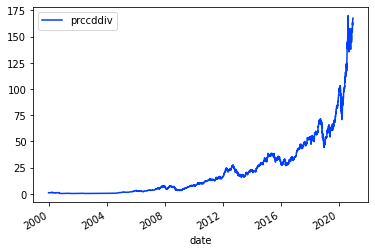

In [28]:
prices_df[prices_df['gvkey+iid']==16901][['date', 'prccddiv']].set_index('date').plot()

<AxesSubplot:xlabel='date'>

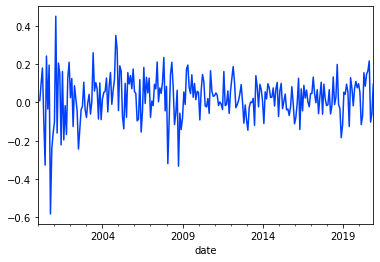

In [29]:
number = 16901
returns_df_shifted[('prccddiv', number)].plot()

# EDA

Добавим в датафрейм столбцы с дисперсиями (чтобы в ходе выполнения модели каждый раз не пересчитывать заново)

In [30]:
data['variance'] = data['std'].apply(lambda x: x**2)
data['variance(+1)'] = data['std(+1)'].apply(lambda x: x**2)

В факторах есть категориальный столбец "сектор". Для корректной работы модели нужно перевести его в формат dummy-переменных:

In [31]:
data = pd.get_dummies(data=data, columns=['sector'], prefix='Sec') #.to_csv('data_for_ev.csv')

In [32]:
data.shape

(171173, 40)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171173 entries, 0 to 171172
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date                        171173 non-null  datetime64[ns]
 1   gvkey+iid                   171173 non-null  int64         
 2   return                      171173 non-null  float64       
 3   gvkey                       171173 non-null  int64         
 4   std                         171173 non-null  float64       
 5   return(+1)                  171173 non-null  float64       
 6   std(+1)                     171173 non-null  float64       
 7   mkval                       171173 non-null  float64       
 8   dividendyield               171173 non-null  float64       
 9   earningsyield               171173 non-null  float64       
 10  roe                         171173 non-null  float64       
 11  roa                         171173 non-

In [34]:
data[['return', 'std','mkval', 'dividendyield', 
      'earningsyield', 'roa', 'roe', 'momentum', 'beta5yr', 'debttoequity', 
      'tradingvolumeusd1m','salesgrowth5yr', 'earningschange5yrtosales']].describe().T

,count,mean,std,min,25%,50%,75%,max
return,171173.0,0.008729,0.110203,-0.989879,-0.042359,0.008967,0.058391,3.583282e+00
std,171173.0,0.079623,0.060358,0.000387,0.044497,0.063465,0.094182,3.040194e+00
mkval,171173.0,23600.053468,56815.798973,1.008750,3857.730100,8897.838250,20476.415820,2.255969e+06
dividendyield,171173.0,1.723958,2.155819,0.000000,0.000000,1.325655,2.626866,1.923077e+02
earningsyield,171173.0,-2.541737,322.198772,-61230.216567,2.550177,4.567347,6.534148,2.118359e+03
roa,171173.0,4.705652,10.189895,-641.126221,1.670633,4.559725,8.511748,9.013363e+01
roe,171173.0,16.877661,279.798117,-7845.944850,6.813464,13.152996,20.560419,4.827610e+04
momentum,171173.0,13.170497,45.229399,-99.954675,-8.392649,10.294478,28.954071,2.605000e+03
beta5yr,171173.0,1.027078,0.424269,-0.286170,0.736411,0.983022,1.259029,2.053139e+01
debttoequity,171173.0,191.768236,2375.964512,0.000000,31.111069,65.881205,129.154753,4.584979e+05


Стандартизация количественных переменных:

In [35]:
quantiles = QuantileTransformer(output_distribution='normal')
scaler = StandardScaler()
data_st = data.copy()
data_st[['mkval',
       'dividendyield', 
       'earningsyield', 
       'roe', 
       'roa', 
       'momentum',
       'tradingvolumeusd1m', 
       'beta5yr', 
       'debttoequity', 
       'salesgrowth5yr',
       'earningschange5yrtosales']] = scaler.fit_transform(quantiles.fit_transform(
                                                                 data[['mkval',
                                                                 'dividendyield', 
                                                                 'earningsyield', 
                                                                 'roe', 
                                                                 'roa', 
                                                                 'momentum',
                                                                 'tradingvolumeusd1m', 
                                                                 'beta5yr', 
                                                                 'debttoequity', 
                                                                 'salesgrowth5yr',
                                                                 'earningschange5yrtosales']]
                                                             )
                                                            )


In [36]:
data_st[['return', 'std','mkval', 'dividendyield', 
      'earningsyield', 'roa', 'roe', 'momentum', 'beta5yr', 'debttoequity', 
      'tradingvolumeusd1m','salesgrowth5yr', 'earningschange5yrtosales']].describe().T#.to_excel('pictures/table3.xlsx')

,count,mean,std,min,25%,50%,75%,max
return,171173.0,8.729238e-03,0.110203,-0.989879,-0.042359,0.008967,0.058391,3.583282
std,171173.0,7.962349e-02,0.060358,0.000387,0.044497,0.063465,0.094182,3.040194
mkval,171173.0,2.125323e-17,1.000003,-5.196110,-0.673270,0.000730,0.674434,5.196385
dividendyield,171173.0,-1.673692e-16,1.000003,-1.560314,-1.560314,0.428201,0.686726,2.415806
earningsyield,171173.0,-1.195494e-17,1.000003,-5.209523,-0.674697,0.001272,0.675921,5.211782
roa,171173.0,7.305797e-18,1.000003,-5.208779,-0.675039,0.001849,0.676672,5.210055
roe,171173.0,9.298287e-18,1.000003,-5.209320,-0.674435,0.000528,0.675754,5.208011
momentum,171173.0,-2.656654e-17,1.000003,-5.198978,-0.673959,0.001600,0.673657,5.199006
beta5yr,171173.0,-2.656654e-17,1.000003,-5.202367,-0.672487,-0.000951,0.674247,5.207360
debttoequity,171173.0,1.328327e-18,1.000003,-3.706613,-0.402230,0.089153,0.582120,3.885047


В итоге, данные подготовлены для построения модели.

# Factor Returns Estimation

## CSR-подход к созданию имитирующих портфелей

Теперь построим кроссекционные регрессии на каждый момент времени dt, чтобы найти коэффициенты чувствительности доходности индекса к факторам

In [37]:
data_st.sample(2)

,date,gvkey+iid,return,gvkey,std,return(+1),std(+1),mkval,dividendyield,earningsyield,roe,roa,momentum,tradingvolumeusd1m,beta5yr,debttoequity,salesgrowth5yr,earningschange5yrtosales,sp500_mean,sp500_std,sp500_mean(+1),sp500_std(+1),risk-free,mkval_sum,ticker,sp500_member,sp500_weight,variance,variance(+1),Sec_Communication Services,Sec_Consumer Discretionary,Sec_Consumer Staples,Sec_Energy,Sec_Financials,Sec_Health Care,Sec_Industrials,Sec_Information Technology,Sec_Materials,Sec_Real Estate,Sec_Utilities
26226,2001-10-31,105301,0.167249,10530,0.127754,-0.171193,0.093419,-0.678164,-1.560314,-0.831431,-0.981051,-0.661943,-1.459121,-1.058947,-0.253516,0.129991,-1.265324,-0.892486,0.015127,0.055571,-0.084694,0.100215,0.003942,9.996992e+06,TMO,1,0.000384,0.016321,0.008727,0,0,0,0,0,0,0,1,0,0,0
60405,2013-02-28,247311,0.046555,24731,0.042653,0.073618,0.022323,-0.000763,0.888404,-0.994096,-1.063988,-0.858887,0.266823,-0.121981,1.563208,0.293713,-0.818730,-1.675523,0.011983,0.038092,0.050203,0.028803,0.001592,1.479212e+07,KIM,1,0.000600,0.001819,0.000498,0,0,0,0,1,0,0,0,0,0,0


In [38]:
y_col = 'return(+1)'
X = data_st
factor_set = ['mkval', 'beta5yr', 'tradingvolumeusd1m', 'momentum', 
       'roa', 'roe', 'dividendyield', 'earningsyield',
       'debttoequity', 'salesgrowth5yr',
       'earningschange5yrtosales', 'Sec_Communication Services',
       'Sec_Consumer Discretionary', 'Sec_Consumer Staples', 'Sec_Energy',
       'Sec_Financials', 'Sec_Health Care', 'Sec_Industrials',
       'Sec_Information Technology', 'Sec_Materials']

factor_returns_tmp_list = []
pvalue_tmp_list = []
regression_analysis = pd.DataFrame(index=data['date'].unique(), dtype='float64', columns=['f_pvalue', 'r2_adj'])

for dt in tqdm(data['date'].unique()): 
        y = X.query('date==@dt and sp500_member==1')[y_col] # define an y-variable
        X_tmp = X.query('date==@dt and sp500_member==1')[factor_set] # define matrix of X regressors
        X_tmp = sm.add_constant(X_tmp) # add constant
        model = sm.OLS(y, X_tmp) # run OLS regression
        results = model.fit() # fit the coefs
        
        factor_returns_tmp = pd.DataFrame(index=pd.DataFrame(results.params).index, 
                                          columns=[dt], 
                                          data=pd.DataFrame(results.params).values) # dataframe of factor returns 
                                                                                    # for current date
        pvalue_tmp = pd.DataFrame(index=pd.DataFrame(results.pvalues).index, 
                                  columns=[dt], 
                                  data=pd.DataFrame(results.pvalues).values)       # dataframe of pvalues
        regression_analysis.loc[dt, 'r2_adj'] = results.rsquared_adj                                                        # for current date
        regression_analysis.loc[dt, 'f_pvalue'] = results.f_pvalue
        factor_returns_tmp_list.append(factor_returns_tmp.T)  # collecting dataframes in list
        pvalue_tmp_list.append(pvalue_tmp.T) 
        
factor_returns_df = pd.concat(factor_returns_tmp_list)  # after cycle has finished, we concatenate list into df
pvalue_df = pd.concat(pvalue_tmp_list)

factor_returns_df = factor_returns_df.drop('const', axis=1) 
pvalue_df = pvalue_df.drop('const', axis=1)

100%|██████████| 251/251 [00:02<00:00, 85.58it/s]


## TSR-подход к созданию имитирующих портфелей

Данный метод в работе не используется по причине отсутствия макроэкономических факторов.

In [39]:
'''
y_col = 'return'
X = data_st

X = X.sort_values(['date'])
factor_set = ['mkval', 'beta5yr', 'tradingvolumeusd1m', 'momentum', 
       'roa', 'roe', 'dividendyield', 'earningsyield',
       'debttoequity', 'salesgrowth5yr',
       'earningschange5yrtosales', 'Sec_Communication Services',
       'Sec_Consumer Discretionary', 'Sec_Consumer Staples', 'Sec_Energy',
       'Sec_Financials', 'Sec_Health Care', 'Sec_Industrials',
       'Sec_Information Technology', 'Sec_Materials']

time_series_betas_list = []
factor_returns_tmp_list = []
pvalue_tmp_list = []
regression_analysis = pd.DataFrame(index=data['date'].unique(), dtype='float64', columns=['f_pvalue', 'r2_adj'])

X = X.rename({'gvkey+iid': 'gvkeyiid'}, axis='columns')

for dt in tqdm(X.query('sp500_member==1')['date'].unique()[31:]): 
    time_series_betas_list = []
    for stock in X.query('sp500_member==1')['gvkeyiid'].unique():
            y = X.query('date<=@dt and sp500_member==1 and gvkeyiid==@stock')[y_col][-30:] # define an y-variable
            if len(y) <= 10:
                continue
            X_tmp = X.query('date<=@dt and sp500_member==1 and gvkeyiid==@stock')[factor_set][-30:] # define matrix of X regressors
            X_tmp = sm.add_constant(X_tmp) # add constant
            model = sm.OLS(y, X_tmp) # run OLS regression
            results = model.fit() # fit the coefs
            
            time_series_betas = pd.DataFrame(index=pd.DataFrame(results.params).index, 
                                                  columns=[stock], 
                                                  data=pd.DataFrame(results.params).values)
            time_series_betas_list.append(time_series_betas.T)
            
    time_series_betas_df = pd.concat(time_series_betas_list).drop('const', axis=1)
    
    stocks_index = time_series_betas_df.index.unique()
    regression = X.query('date<=@dt and gvkeyiid in @stocks_index').groupby('gvkeyiid')['return'].mean()
    regression = regression.sort_index()
    regressors = time_series_betas_df.sort_index()
    regressors = sm.add_constant(regressors)
    model = sm.OLS(regression, regressors)
    results = model.fit()

    factor_returns_tmp = pd.DataFrame(index=pd.DataFrame(results.params).index, 
                                              columns=[dt], 
                                              data=pd.DataFrame(results.params).values) # dataframe of factor returns 
                                                                                        # for current date
    pvalue_tmp = pd.DataFrame(index=pd.DataFrame(results.pvalues).index, 
                                      columns=[dt], 
                                      data=pd.DataFrame(results.pvalues).values)       # dataframe of pvalues
    regression_analysis.loc[dt, 'r2_adj'] = results.rsquared_adj                                                        # for current date
    regression_analysis.loc[dt, 'f_pvalue'] = results.f_pvalue
    factor_returns_tmp_list.append(factor_returns_tmp.T)  # collecting dataframes in list
    pvalue_tmp_list.append(pvalue_tmp.T) 
        
factor_returns_df = pd.concat(factor_returns_tmp_list)  # after cycle has finished, we concatenate list into df
pvalue_df = pd.concat(pvalue_tmp_list)

factor_returns_df = factor_returns_df.drop('const', axis=1) 
pvalue_df = pvalue_df.drop('const', axis=1)

'''

"\ny_col = 'return'\nX = data_st\n\nX = X.sort_values(['date'])\nfactor_set = ['mkval', 'beta5yr', 'tradingvolumeusd1m', 'momentum', \n       'roa', 'roe', 'dividendyield', 'earningsyield',\n       'debttoequity', 'salesgrowth5yr',\n       'earningschange5yrtosales', 'Sec_Communication Services',\n       'Sec_Consumer Discretionary', 'Sec_Consumer Staples', 'Sec_Energy',\n       'Sec_Financials', 'Sec_Health Care', 'Sec_Industrials',\n       'Sec_Information Technology', 'Sec_Materials']\n\ntime_series_betas_list = []\nfactor_returns_tmp_list = []\npvalue_tmp_list = []\nregression_analysis = pd.DataFrame(index=data['date'].unique(), dtype='float64', columns=['f_pvalue', 'r2_adj'])\n\nX = X.rename({'gvkey+iid': 'gvkeyiid'}, axis='columns')\n\nfor dt in tqdm(X.query('sp500_member==1')['date'].unique()[31:]): \n    time_series_betas_list = []\n    for stock in X.query('sp500_member==1')['gvkeyiid'].unique():\n            y = X.query('date<=@dt and sp500_member==1 and gvkeyiid==@stock')[y_

factor_returns_df.to_excel('pictures/Factor_returns_table_model'+str(i)+'.xlsx')

pvalue_df.to_excel('pictures/Pvalues_table_model'+str(i)+'.xlsx')

## Cumulative Factor Returns

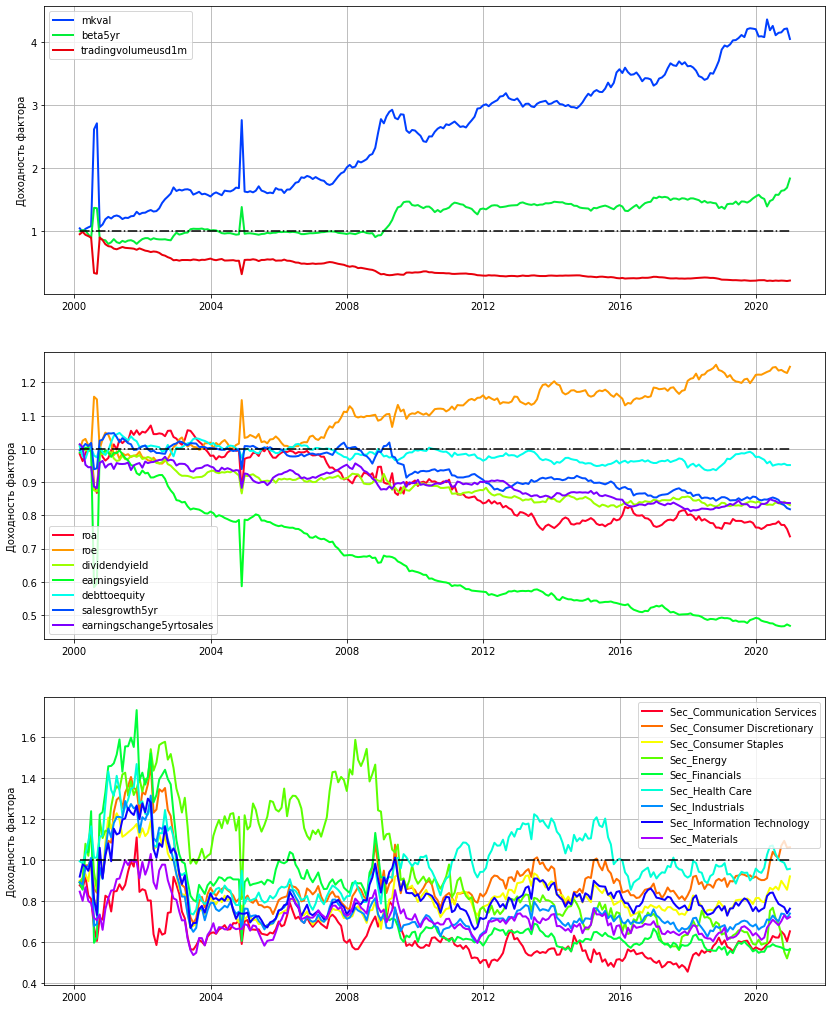

In [40]:
fig, (axs0, axs1, axs2,) = plt.subplots(3, 1, figsize=(14, 18))
fig.subplots_adjust(hspace=0.2)
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS1 = len(factor_returns_df.columns[4:11])
NUM_COLORS2 = len(factor_returns_df.columns[11:])
axs1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS1) for i in range(NUM_COLORS1)])
axs2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS2) for i in range(NUM_COLORS2)])

for factor in factor_returns_df.columns[:3]:
    sns.lineplot(x=factor_returns_df.index, 
                 y=factor_returns_df[factor].apply(lambda x: x+1).cumprod(), 
                 label=factor, 
                 lw=2.0, ax=axs0)
sns.lineplot(x=factor_returns_df.index, 
             y=1.0, ax=axs0, 
             linestyle='-.', color='black')
#axs0.set_title('Кумулятивные доходности количественных факторов', fontsize='xx-large')
axs0.set_ylabel('Доходность фактора')
axs0.set_xlabel('')
axs0.grid()
axs0.legend()


for factor in factor_returns_df.columns[4:11]:
    sns.lineplot(x=factor_returns_df.index, 
                 y=factor_returns_df[factor].apply(lambda x: x+1).cumprod(), 
                 label=factor, 
                 lw=2.0, ax=axs1)
sns.lineplot(x=factor_returns_df.index, 
             y=1.0, ax=axs1, 
             linestyle='-.', color='black')
#axs1.set_title('Кумулятивные доходности количественных факторов', fontsize='xx-large')
axs1.set_ylabel('Доходность фактора')
axs1.set_xlabel('')
axs1.grid()
axs1.legend()

for factor in factor_returns_df.columns[11:]:
    sns.lineplot(x=factor_returns_df.index, 
                 y=factor_returns_df[factor].apply(lambda x: x+1).cumprod(), 
                 label=factor, 
                 lw=2.0, ax=axs2)
sns.lineplot(x=factor_returns_df.index, 
             y=1.0, ax=axs2, 
             linestyle='-.', color='black')
#axs2.set_title('Кумулятивные доходности бинарных факторов', fontsize='xx-large')
axs2.set_ylabel('Доходность фактора')
axs2.set_xlabel('')
axs2.grid()
axs2.legend()
plt.show()

#fig.savefig('pictures/Returns' + str(i) + '.jpg')

extent0 = axs0.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
extent1 = axs1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
extent2 = axs2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# Pad the saved area by 15% in the x-direction and 15% in the y-direction
#fig.savefig('pictures/Top-3_factor_returns.jpg', bbox_inches=extent0.expanded(1.15, 1.15))
#fig.savefig('pictures/quant_factor_returns.jpg', bbox_inches=extent1.expanded(1.15, 1.15))
#fig.savefig('pictures/qual_factor_returns.jpg', bbox_inches=extent2.expanded(1.15, 1.15))

In [41]:
pd.DataFrame(pd.Series(index=factor_returns_df.columns[:3], 
                       data=[st.gmean(factor_returns_df[factor].apply(lambda x: x+1)) -1 for factor in factor_returns_df.columns[:3]], 
                       name='mean factor return')).to_excel('pictures/table7_model'+str(i)+'.xlsx')

In [42]:
pd.DataFrame(pd.Series(index=factor_returns_df.columns[4:11], 
                       data=[st.gmean(factor_returns_df[factor].apply(lambda x: x+1)) -1 for factor in factor_returns_df.columns[4:11]], 
                       name='mean factor return')).to_excel('pictures/table8_model'+str(i)+'.xlsx')

In [43]:
pd.DataFrame(pd.Series(index=factor_returns_df.columns[11:], 
                       data=[st.gmean(factor_returns_df[factor].apply(lambda x: x+1)) -1 for factor in factor_returns_df.columns[11:]], 
                       name='mean factor return')).to_excel('pictures/table9_model'+str(i)+'.xlsx')

## Regression Analysis

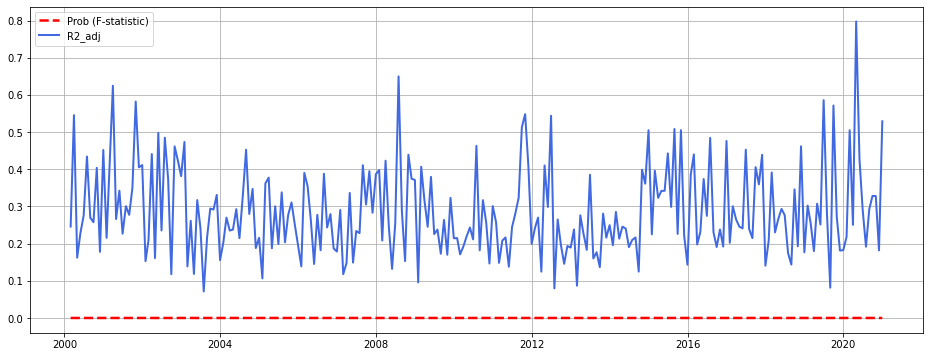

In [44]:
fig, (axs3) = plt.subplots(1, 1, figsize=(16, 6))
fig.subplots_adjust(hspace=0.1)
sns.lineplot(x=regression_analysis.index, 
             y=regression_analysis['f_pvalue'].values, 
             label='Prob (F-statistic)', 
             lw=2.5, ax=axs3, color='red', ls='--')
sns.lineplot(x=regression_analysis.index, 
             y=regression_analysis['r2_adj'].values, 
             label='R2_adj', ax=axs3, lw=2.0, color='royalblue')
#axs3.set_title('Анализ регрессии', fontsize='xx-large')
axs3.set_ylabel('')
axs3.set_xlabel('')
axs3.grid()
axs3.legend()
#plt.show()
#fig.tight_layout()
#fig.savefig('pictures/regression' + str(i) + '.jpg')

In [45]:
regression_analysis['r2_adj'].mean()

0.28573571724916197

# Portfolio Selection

In [46]:
start = 31
alpha = .1
#, options={'maxiter': 10, 'disp': False}

In [47]:
def calculate_VaR_HS(ret, alpha=alpha):

    return ret.quantile(alpha)

def calc_VaR(r, VaR_fun, L_history=252, level=alpha):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

После того, как вычислены доходности факторов, можно приступить к оптимизации портфеля с помощью пакета 'scipy.optimize'

In [48]:
def objective(weights): # objective function to be minimized
    return np.dot(np.dot(weights, risks_tmp), np.transpose(weights))
        
def constraint2(weights): # sum of weights must be equal to 1 (or sum - 1 = 0)
    return np.sum(weights)-1.0

def constraint1(weights): # return of estimated portfolio on given date must be equal
    return np.dot(weights, returns_tmp) - sp500_return_tmp  # to the sp500 return on that date

# initializing lists to capture the history of calculations
returns_list = []
risks_list = []
solution_list = []
sector_weights_list = []

portfolio_performance = pd.DataFrame(columns=['Risk Free Rate', 'MFM Optimized Return', 
                                              'MFM Optimized Excess Return', 'MFM Actual Optimized Excess Return',
                                              'MFM Optimized Std', 'MFM Actual Optimized Return',
                                              'MFM Optimized Sharpe'
                                              'MFM Return','MFM Excess Return',
                                              'MFM Std', 'MFM Sharpe', 'Markowitz Return'
                                              'Markowitz Excess Return',
                                              'Markowitz Std', 'Markowitz Sharpe',
                                              'S&P 500 Return', 
                                              'S&P 500 Excess Return',
                                              'S&P 500 Std',
                                              'S&P 500 Sharpe'], 
                                    index=data['date'].unique()[start:], 
                                    dtype='float64')

portfolio_performance['Risk Free Rate'] = risk_free['risk-free'][start:]
portfolio_performance['S&P 500 Excess Return'] = sp500['sp500_mean'][start:]
portfolio_performance['S&P 500 Std'] = sp500['sp500_std'][start:]

for dt in tqdm(data.sort_values('date')['date'].unique()[start:]): # for each date:
    if dt >= data['date'].unique()[1]:  # just to make sure cov is not calculated over a single observation
        # retrieving exposures of assets to factors (n-assets x k-factors)
        exposures = (data_st.query('date==@dt and sp500_member==1')
                     .drop('date', axis=1).set_index(['gvkey+iid'])[factor_set])
        
        # setting the desired level of return of estimated portfolio (to be used in constraint2)
        sp500_return_tmp = sp500.query('date==@dt')['sp500_mean']
        sp500_weights_tmp = data.query('date==@dt and sp500_member==1')['sp500_weight']
        risk_free_return = risk_free.loc[dt]['risk-free']
        sp500_return_tmp = sp500_return_tmp - risk_free_return
        
        # calculating the covariance matrix of factor returns (k x k)
        #cov = factor_returns_df.rolling(12).cov().loc[dt]
        cov = factor_returns_df.loc[:dt].cov()
        
        # calculate mean-returns using the estimated factor returns and asset exposures to factors
        returns_tmp = pd.DataFrame(index=exposures.index.unique(), 
                                   columns=[dt], 
                                   data=np.dot(exposures, factor_returns_df.loc[dt].T)) # (n x k) x (k x 1) = (n x 1)
        returns_list.append(returns_tmp.T) # why not to save these calculated means =)
        
        # calculate the Σ-matrix (to be used in portfolio volatility estimation)
        risks_tmp = np.dot(np.dot(exposures, cov), exposures.T) # (n x k) x (k x k) x (k x n) = (n x n)
        
        risks_list.append(risks_tmp)
        
        # extract historical returns of stocks
        markowitz_returns_tmp = returns_df.fillna(0).loc[:dt].mean().T\
                                .loc[[('prccddiv', i) for i in exposures.index]]
        
        #real_returns_tmp = returns_df.fillna(0).loc[dt].T\
                                #.reset_index(0, drop=True).loc[exposures.index]
            
        real_returns_tmp = returns_df.fillna(0).loc[dt].T\
                           .loc[[('prccddiv', i) for i in exposures.index]]
        # calculate covariance matrix based on actual returns history (to compare modelled and real performance)
        #cov_m = returns_df.fillna(0).T.loc[exposures.index].T.loc[:dt].rolling(12).cov()
        cov_m = returns_df.fillna(0).T.loc[[('prccddiv', i) for i in exposures.index]].T.loc[:dt].cov()
        
        # generate some starting weights for optimization
        uniform = np.random.default_rng(666).uniform(low=0.0, high=1.0, size=len(exposures.index.unique()))
        weights0 = uniform / np.sum(uniform)   # to  ensure the sum of generated random variables == 1.0
        
    
        x0 = weights0  # some starting weights for minimization
        b = (0.0, 1.0) # changing limits for weights
        bnds = tuple([b] * len(exposures.index.unique())) # these bounds must be applied for all assets
        con1 = {'type': 'eq', 'fun': constraint1} # setting constraints as recommended by scipy package
        con2 = {'type': 'eq', 'fun': constraint2} # another constraint
        cons = [con1, con2] # combining constraints
        solution = minimize(objective, x0, 
                            method='SLSQP', bounds=bnds, 
                            constraints=cons, 
                            options={'maxiter': 50, 'disp': False}) # minimization of volatility
            # with the desired level of return (equal to sp500)
        solution_list.append(solution.x)
        
        portfolio_performance.loc[dt, 'MFM Optimized Excess Return'] = np.dot(np.transpose(solution.x), 
                                                                              returns_tmp) # final calculation 
                                                                                  # of portfolio return
        portfolio_performance.loc[dt, 'MFM Actual Optimized Excess Return'] = np.dot(np.transpose(solution.x), 
                                                                                     real_returns_tmp) # final calculation 
                                                                                  # of portfolio return
            
        portfolio_performance.loc[dt, 'MFM Optimized Std'] = np.sqrt(np.dot(np.dot(np.transpose(solution.x), 
                                                                                   risks_tmp), solution.x)) # and portfolio risk
        
        portfolio_performance.loc[dt, 'MFM Excess Return'] = np.dot(np.transpose(sp500_weights_tmp), 
                                                                    returns_tmp) 
                                                                    
        portfolio_performance.loc[dt, 'MFM Std'] = np.sqrt(np.dot(np.dot(np.transpose(sp500_weights_tmp), 
                                                                         risks_tmp), sp500_weights_tmp)) # and portfolio risk
        
        sector_weights_list.append(np.dot(exposures[['Sec_Communication Services',
       'Sec_Consumer Discretionary', 'Sec_Consumer Staples', 'Sec_Energy',
       'Sec_Financials', 'Sec_Health Care', 'Sec_Industrials',
       'Sec_Information Technology', 'Sec_Materials']].T, solution.x))
        
        # calculate the Markowitz performance of calculated portfolio
        portfolio_performance.loc[dt, 'Markowitz Excess Return'] = np.dot(sp500_weights_tmp, 
                                                                          markowitz_returns_tmp) 
        portfolio_performance.loc[dt, 'Markowitz Std'] = np.sqrt(np.dot(np.dot(np.transpose(sp500_weights_tmp), 
                                                                               cov_m.fillna(0)), sp500_weights_tmp))
        portfolio_performance.loc[dt, 'MFM Optimized Sharpe'] = portfolio_performance.loc[:dt, 'MFM Excess Return'].mean() /\
                                                    portfolio_performance.loc[:dt, 'MFM Std'].mean()
        portfolio_performance.loc[dt, 'Markowitz Sharpe'] = portfolio_performance.loc[:dt, 'Markowitz Excess Return'].mean() /\
                                                    portfolio_performance.loc[:dt, 'Markowitz Std'].mean()
        portfolio_performance.loc[dt, 'S&P 500 Sharpe'] = portfolio_performance.loc[:dt, 'S&P 500 Excess Return'].mean() /\
                                                    portfolio_performance.loc[:dt, 'S&P 500 Std'].mean()
        
    else: 
        pass

returns_df_1 = pd.concat(returns_list, axis=0, join='outer')

portfolio_performance['MFM Actual Optimized Return'] = portfolio_performance['MFM Actual Optimized Excess Return'] + portfolio_performance['Risk Free Rate']
portfolio_performance['MFM Return'] = portfolio_performance['MFM Excess Return'] + portfolio_performance['Risk Free Rate']
portfolio_performance['MFM Optimized Return'] = portfolio_performance['MFM Optimized Excess Return'] + portfolio_performance['Risk Free Rate']
portfolio_performance['Markowitz Return'] = portfolio_performance['Markowitz Excess Return'] + portfolio_performance['Risk Free Rate']
portfolio_performance['S&P 500 Return'] = portfolio_performance['S&P 500 Excess Return'] + portfolio_performance['Risk Free Rate']


100%|██████████| 220/220 [51:42<00:00, 14.10s/it] 


<div class="alert alert-info">
    <font size="5"><b>Комментарий</b></font>
    
На данном этапе считается ковариационная матрица факторов (cov), которая после перемножения на матрицу значений exposures используется для минимизации волатильности портфеля при заданной доходности (S&P500)

Полученные доходность и волатильность портфеля сравниваются с т.н. настоящими доходностью и волатильностью портфеля (настоящая доходность портфеля вычисляется как взвешенная доходность на основе реальных доходностей акций). То есть оптимизированные с помощью модели веса используются для подсчета реальных характеристик портфеля.
</div>

In [49]:
portfolio_performance['MFM Return VaR ' + str(alpha)] = calc_VaR(portfolio_performance['MFM Return'], 
                                                               calculate_VaR_HS, 
                                                               L_history=60, 
                                                               level=alpha)
portfolio_performance['MFM Optimized Return VaR ' + str(alpha)] = calc_VaR(portfolio_performance['MFM Optimized Return'], 
                                                               calculate_VaR_HS, 
                                                               L_history=60, 
                                                               level=alpha)
portfolio_performance['S&P 500 Return VaR ' + str(alpha)] = calc_VaR(portfolio_performance['S&P 500 Return'], 
                                                               calculate_VaR_HS, 
                                                               L_history=60, 
                                                               level=alpha)
portfolio_performance['Markowitz Return VaR ' + str(alpha)] = calc_VaR(portfolio_performance['Markowitz Return'], 
                                                               calculate_VaR_HS, 
                                                               L_history=60, 
                                                               level=alpha)

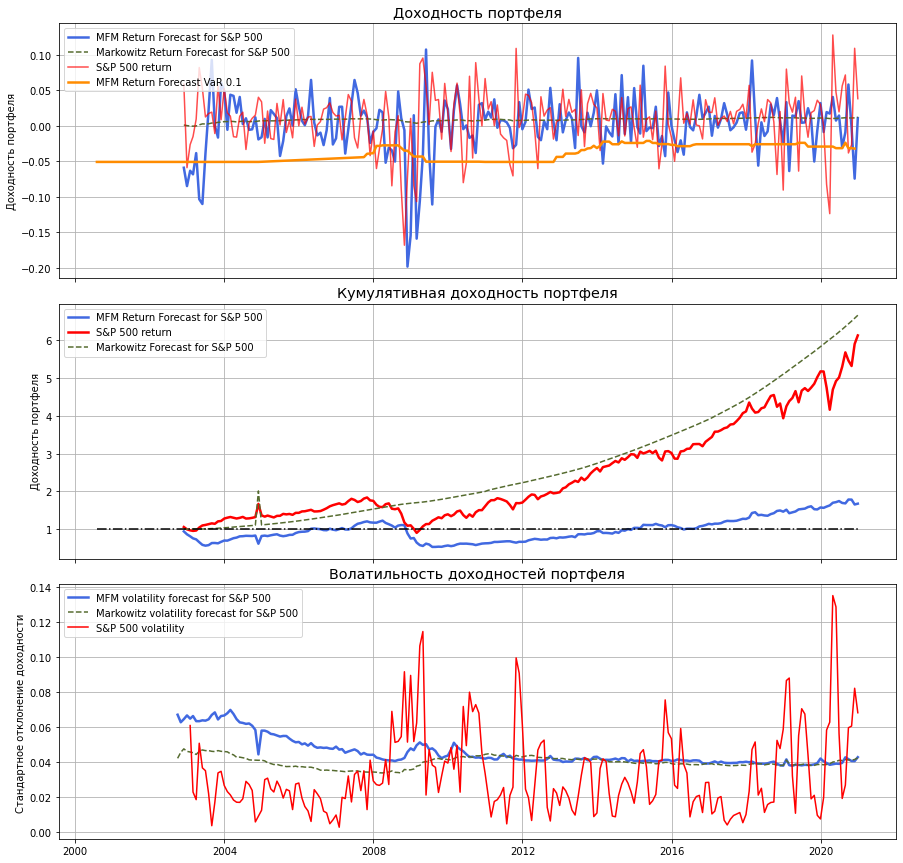

In [50]:
fig, (axs0, axs1, axs2) = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
fig.subplots_adjust(hspace=0.1)

sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Std'].values, 
             label='MFM volatility forecast for S&P 500', 
             lw=2.5, ax=axs2, color='royalblue')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['Markowitz Std'].values, 
             label='Markowitz volatility forecast for S&P 500', ax=axs2, 
             ls='--', lw=1.5, color='darkolivegreen')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['S&P 500 Return'].rolling(3).std(), 
             label='S&P 500 volatility', ax=axs2, color='red')
axs2.set_title('Волатильность доходностей портфеля', fontsize='x-large')
axs2.set_ylabel('Стандартное отклонение доходности ')
axs2.set_xlabel('')
axs2.grid()
axs2.legend()


sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Return'].apply(lambda x: x+1.002).cumprod(), 
             label='MFM Return Forecast for S&P 500', 
             ax=axs1, lw=2.5, color='royalblue')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['S&P 500 Return'].apply(lambda x: x+1).cumprod(), 
             label='S&P 500 return', 
             ax=axs1, lw=2.5, color='red')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['Markowitz Return'].apply(lambda x: x+1).cumprod(), 
             label='Markowitz Forecast for S&P 500', ax=axs1, ls='--', lw=1.5, color='darkolivegreen')
sns.lineplot(x=portfolio_performance.index, 
             y=1.0, ax=axs1, 
             linestyle='-.', color='black')
axs1.set_title('Кумулятивная доходность портфеля', fontsize='x-large')
axs1.set_ylabel('Доходность портфеля')
axs1.set_xlabel('')
axs1.grid()
axs1.legend()

sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Return'], 
             label='MFM Return Forecast for S&P 500', 
             ax=axs0, lw=2.5, color='royalblue')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['Markowitz Return'], 
             label='Markowitz Return Forecast for S&P 500', ax=axs0, ls='--', lw=1.5, color='darkolivegreen')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['S&P 500 Return'], 
             label='S&P 500 return', ax=axs0, alpha=0.7, color='red')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Return VaR ' + str(alpha)].shift(-3).values, 
             label='MFM Return Forecast VaR ' + str(alpha), 
             ax=axs0, lw=2.5, color='darkorange')
axs0.set_title('Доходность портфеля', fontsize='x-large')
axs0.set_ylabel('Доходность портфеля')
axs0.set_xlabel('')
axs0.grid()
axs0.legend(loc='upper left')


plt.show()
#fig.tight_layout()
#fig.savefig('pictures/Model_' + str(i) + '.jpg')

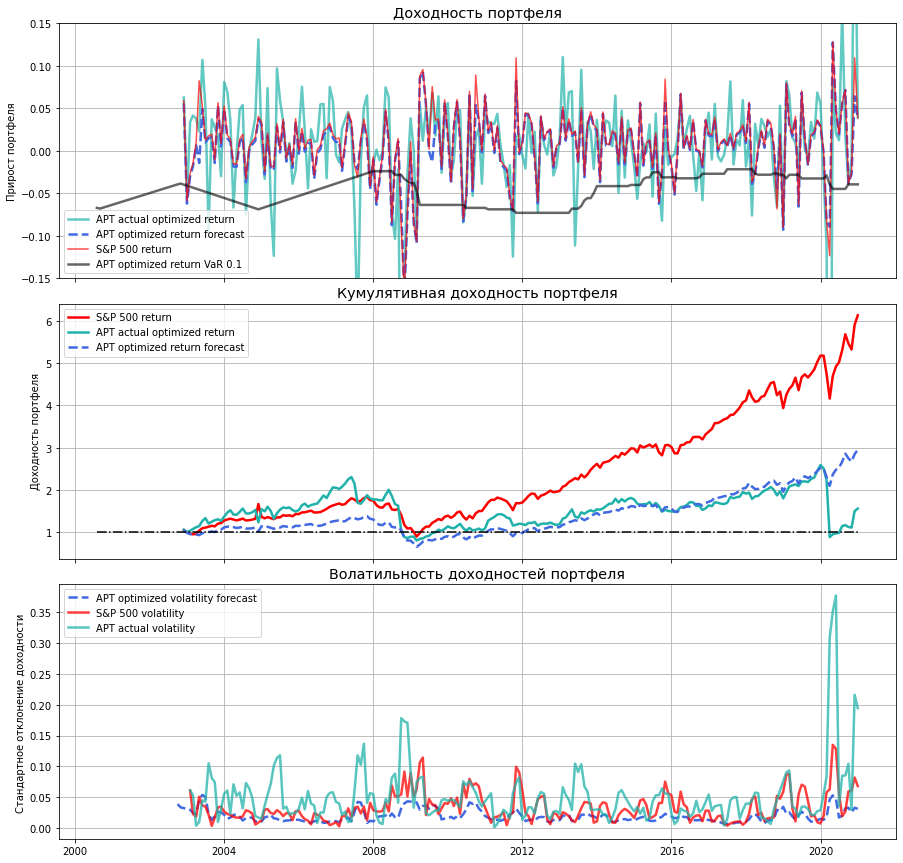

In [51]:
fig, (axs0, axs1, axs2) = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
fig.subplots_adjust(hspace=0.1)

sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Optimized Std'].rolling(3).mean().values, 
             label='APT optimized volatility forecast', 
             lw=2.5, ls='--', ax=axs2, color='royalblue')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['S&P 500 Return'].rolling(3).std().values, 
             label='S&P 500 volatility', ax=axs2, lw=2.5, color='red', alpha=0.75)
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Actual Optimized Return'].rolling(3).std().values, 
             label='APT actual volatility', ax=axs2, lw=2.5, color='lightseagreen', alpha=0.75)
axs2.set_title('Волатильность доходностей портфеля', fontsize='x-large')
axs2.set_ylabel('Стандартное отклонение доходности ')
axs2.set_xlabel('')
axs2.grid()
axs2.legend()


#performance = 'MFM forecast: | Markowitz forecast | S&P 500' + str('\n') + 'Return = ' + str(np.round(portfolio_performance['MFM Return'][-1], 3)) + '|'

#axs1.text(portfolio_performance.index[-int(np.round(len(portfolio_performance.index[start:])/4, 0))], 
          #0.9, 
          #performance, 
          #style='italic',
        #bbox={'facecolor': 'beige', 'alpha': 0.5, 'pad': 15})


sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['S&P 500 Return'].apply(lambda x: x+1).cumprod(), 
             label='S&P 500 return', 
             ax=axs1, lw=2.5, color='red')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Actual Optimized Return'].apply(lambda x: x+1).cumprod(), 
             label='APT actual optimized return', ax=axs1, lw=2.5, color='lightseagreen')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Optimized Return'].apply(lambda x: x+1).cumprod(), 
             label='APT optimized return forecast', 
             ax=axs1, lw=2.5, ls='--', color='royalblue')
sns.lineplot(x=portfolio_performance.index, 
             y=1.0, ax=axs1, 
             linestyle='-.', color='black')

axs1.set_title('Кумулятивная доходность портфеля', fontsize='x-large')
axs1.set_ylabel('Доходность портфеля')
axs1.set_xlabel('')
#axs1.set_ylim(0, 15)
axs1.grid()
axs1.legend()




sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Actual Optimized Return'], 
             label='APT actual optimized return', 
             ax=axs0, lw=2.5, color='lightseagreen', alpha=0.7)
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Optimized Return'], 
             label='APT optimized return forecast', 
             ax=axs0, ls='--', lw=2.5, color='royalblue')
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['S&P 500 Return'], 
             label='S&P 500 return', 
             ax=axs0, lw=1.5, color='red', alpha=0.7)
sns.lineplot(x=portfolio_performance.index, 
             y=portfolio_performance['MFM Optimized Return VaR ' + str(alpha)].values, 
             label='APT optimized return VaR ' + str(alpha), 
             ax=axs0, lw=2.5, color='black', alpha=0.6)


axs0.set_title('Доходность портфеля', fontsize='x-large')
axs0.set_ylabel('Прирост портфеля')
axs0.set_ylim(-0.15, 0.15)
axs0.set_xlabel('')
axs0.grid()
axs0.legend()

plt.show()
fig.tight_layout()
fig.savefig('pictures/Model_Magistratura_optimized.jpg')

## Backtesting

Bernoulli Coverage and Independence Tests

In [52]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))

def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [53]:
backtest_results(portfolio_performance['S&P 500 Return'], 
                 portfolio_performance['MFM Optimized Return VaR ' + str(alpha)], 
                 alpha)

Target share of violations: 10.00%
Observed share of violations: 11.11%

Test for coverage is passed

Test for independence isn't passed


In [54]:
backtest_results(portfolio_performance['S&P 500 Return'], 
                 portfolio_performance['MFM Return VaR ' + str(alpha)], 
                 alpha)

Target share of violations: 10.00%
Observed share of violations: 14.81%

Test for coverage is passed

Test for independence is passed


In [55]:
portfolio_performance.to_excel('pictures/portfolio_performance model '+str(i)+'.xlsx')

In [56]:
portfolio_performance

,Risk Free Rate,MFM Optimized Return,MFM Optimized Excess Return,MFM Actual Optimized Excess Return,MFM Optimized Std,MFM Actual Optimized Return,MFM Optimized SharpeMFM Return,MFM Excess Return,MFM Std,MFM Sharpe,Markowitz ReturnMarkowitz Excess Return,Markowitz Std,Markowitz Sharpe,S&P 500 Return,S&P 500 Excess Return,S&P 500 Std,S&P 500 Sharpe,Markowitz Excess Return,MFM Optimized Sharpe,MFM Return,Markowitz Return,MFM Return VaR 0.1,MFM Optimized Return VaR 0.1,S&P 500 Return VaR 0.1,Markowitz Return VaR 0.1
2002-11-30,0.003283,0.055576,0.052292,0.059391,0.035099,0.062675,NaN,-0.062119,0.064384,NaN,NaN,0.047412,-0.039798,0.058859,0.055576,0.068741,0.808483,-0.001887,-0.964820,-0.058836,0.001396,NaN,NaN,NaN,NaN
2002-12-31,0.003375,-0.062123,-0.065498,-0.058011,0.029332,-0.054636,NaN,-0.088029,0.066522,NaN,NaN,0.045967,-0.050714,-0.058748,-0.062123,0.050743,-0.054792,-0.002849,-1.146991,-0.084654,0.000526,NaN,NaN,NaN,NaN
2003-01-31,0.003358,-0.029555,-0.032913,0.030595,0.024460,0.033954,NaN,-0.066390,0.064663,NaN,NaN,0.045605,-0.058652,-0.026197,-0.029555,0.073352,-0.187215,-0.003416,-1.107216,-0.063031,-0.000058,NaN,NaN,NaN,NaN
2003-02-28,0.003375,-0.018379,-0.021754,0.038132,0.020640,0.041507,NaN,-0.071477,0.066156,NaN,NaN,0.045203,-0.064091,-0.015004,-0.018379,0.054334,-0.220418,-0.003653,-1.100446,-0.068102,-0.000278,NaN,NaN,NaN,NaN
2003-03-31,0.003250,0.006459,0.003209,0.034738,0.022241,0.037988,NaN,-0.041468,0.063247,NaN,NaN,0.044208,-0.065798,0.009709,0.006459,0.080298,-0.146644,-0.003223,-1.013879,-0.038218,0.000027,NaN,NaN,NaN,NaN
2003-04-30,0.003175,-0.014346,-0.017521,0.019680,0.097679,0.022855,NaN,-0.106307,0.063221,NaN,NaN,0.045994,-0.060390,0.082370,0.079195,0.053896,0.081743,-0.001542,-1.122610,-0.103132,0.001633,NaN,NaN,NaN,NaN
2003-05-31,0.003300,0.049388,0.046088,0.103839,0.041182,0.107139,NaN,-0.113202,0.063709,NaN,NaN,0.046784,-0.052657,0.052688,0.049388,0.046987,0.188074,-0.000342,-1.214847,-0.109902,0.002958,NaN,NaN,NaN,NaN
2003-06-30,0.002975,0.009781,0.006806,0.048657,0.013362,0.051632,NaN,-0.041768,0.063524,NaN,NaN,0.046397,-0.046346,0.012756,0.009781,0.046002,0.190455,-0.000123,-1.146158,-0.038793,0.002852,NaN,NaN,NaN,NaN
2003-07-31,0.002775,0.014857,0.012082,-0.098729,0.012379,-0.095954,NaN,0.020594,0.064292,NaN,NaN,0.046408,-0.040449,0.017632,0.014857,0.045104,0.202518,0.000291,-0.983523,0.023369,0.003066,NaN,NaN,NaN,NaN
2003-08-31,0.003317,0.016185,0.012869,0.033736,0.014009,0.037053,NaN,0.089816,0.066804,NaN,NaN,0.045993,-0.034555,0.019502,0.016185,0.031528,0.220305,0.000850,-0.742975,0.093133,0.004167,NaN,NaN,NaN,NaN
